## Empty homes for good?
> "When people in England get on a bus or a train, they are happy to see a seat empty. When people in England go to the shop to buy milk, they are happy to see an unsold bottle rather than an empty shelf. But when it comes to homes, many people in England think about things differently. Empty homes, they say, are a bad thing, to be reduced by policy, and to be filled before any new homes should be permitted."

In 2022, our head of data, Tom Forth, wrote the above in a blog post about empty homes. There is a way of thinking that suggests having a high rate (~10%) of empty homes is essential for a functioning housing market. One aspect of this discussion revolves around the effect of vacant homes on house prices. Simplistically, if you're a homeowner, you probably wouldn't want house prices to decrease. However, if you're yet to get on the housing ladder, or can only afford to rent, then you'd probably be OK with house prices dropping. But what does the data say about vacant homes and house prices?

Import some utility modules and set paths

In [1]:
from pathlib import Path
from scipy import stats
import pandas as pd
import seaborn as sns
ROOT = Path('../')
ROOT.resolve()

PosixPath('/Users/lukestrange/Code/housing')

Load the data. We processed this in `pipelines` for the visualisations on the site.

For house prices:
- re-index the rows
- only include rows with "March" in the date column - this gives 1 data point per place per year. 
- convert the date to just the year part.

For vacant homes:
- re-index the rows
- add a 'Year' column

To combine:
- Merge the house prices and vacant homes data
- Create a column to say whether or not the place is a London borough.

In [2]:
vacant_homes = pd.read_parquet(ROOT / "data/vacant-homes/site/percentages.parquet")
house_prices = pd.read_parquet(ROOT / "data/house-prices/site/median_house_prices.parquet")

hp = house_prices.reset_index()
hp = hp.loc[hp['date'].str.contains('Mar')]
hp['date'] = pd.to_datetime(hp['date'], format="%b %Y")
hp['year'] = hp['date'].dt.year.astype(int)

vh = vacant_homes.reset_index()
vh['year'] = vh['date']

merged = vh.merge(hp, on=['geography_code', 'geography_name', 'year'])
merged['London Borough'] = merged['geography_code'].str.startswith('E09')


In [3]:
def susbet(data, years=['all'], include_london=True):
    """
    Filter the dataframe.

    Params
    ------
    data : pd.dataframe
        dataframe to filter
    years : list
        list of years, or list containing str 'all'
    include_london: boolean
        whether to include london boroughs

    Returns
    -------
    pd.dataframe
        Subset of the dataframe
    """
    if not include_london:
        data[data['London Borough'] == False]

    n_years = len(years)
    if n_years==1 and years[0] == 'all':
        pass
    elif n_years > 0 and 'all' not in years:
        data[data['year'].isin(years)]
    else:
        print('Falling back to all years.')
    return data

def scatter_plot(data, x, y, hue):
    """
    Make a scatterplot using seaborn.

    Params
    ------
    data : pd.dataframe
        dataframe contianing the data
    x : str
        column title to plot on x-axis
    y : str
        column title to plot on y-axis
    hue: str
        column to use to colour the data points

    Returns
    -------
    sns.scatterplot
        The plot
    """
    if hue not in data.columns:
        print(f'Column suggested for HUE is not in the dataframe. Check the spelling of {hue}.\n Columns present are {data.columns.to_list()}')
        hue=None
    return sns.scatterplot(data, x=x, y=y, hue=hue)

def spearman(data, x, y):
    """
    Calculate the spearman correlation between two series in a dataframe

    Params
    ------
    data : pd.dataframe
        dataframe contianing the data
    x : str
        column containing x-values
    y : str
        column containing y-values

    Returns
    -------
    float, float
        Correlation coefficient, p-value 
    """
    assert x in data.columns, f'{x} not a column in the dataframe'
    assert y in data.columns, f'{y} not a column in the dataframe'
    x, y = merged[x], merged[y]
    res = stats.spearmanr(x, y)
    print('Spearman correlation coefficient: ', res.statistic, 'p-value: ', res.pvalue)
    return res.statistic, res.pvalue

Make a scatter plot of Median house prices against vacant homes percentage for all areas every year since 2004.

Are Median house prices and the percentage of vacant homes correlated?
We'll use a spearman's rank test because:
- the data are not normally distributed.
- the relationship is not necessarily linear.
- Outliers are present.
- There is limited resolution in house prices, so the data are effectively discretised.

Spearman correlation coefficient:  -0.7015431434015463 p-value:  0.0005668754524794646


(np.float64(-0.7015431434015463), np.float64(0.0005668754524794646))

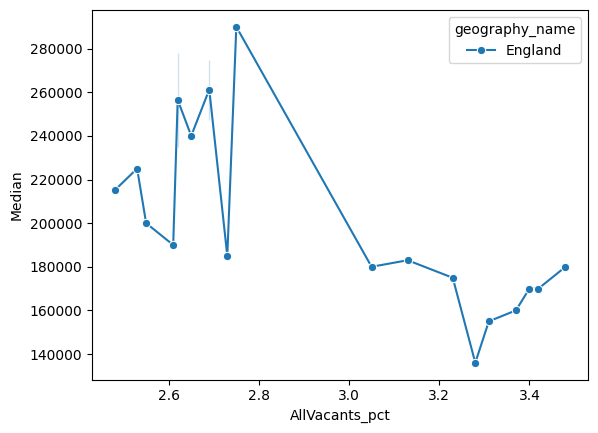

In [4]:
x = 'AllVacants_pct'
y = 'Median'
hue = 'London Borough'
merged = merged[merged.geography_code.str.startswith('E92')]
sns.lineplot(data=merged, x=x, y=y, marker='o', hue='geography_name')
spearman(merged, x, y)

Spearman correlation coefficient:  -0.698532228622999 p-value:  0.0006128494269697435


(np.float64(-0.698532228622999), np.float64(0.0006128494269697435))

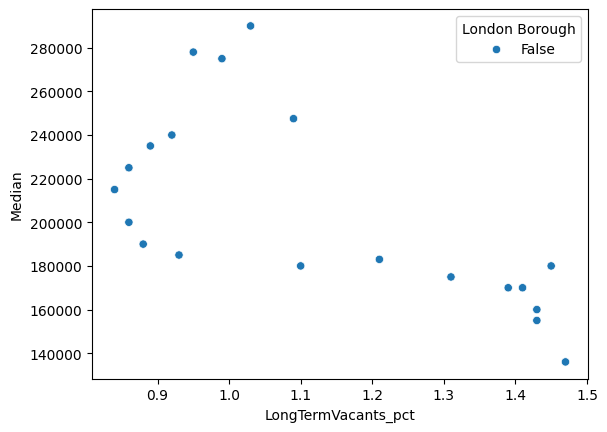

In [5]:
x = 'LongTermVacants_pct'
y = 'Median'
hue = 'London Borough'
scatter_plot(merged, x, y, hue)
spearman(merged, x, y)

## What does this mean?
- A correlation coefficient of ~ -0.6 shows a moderate inverse relationship between house prices and peercentage of vacant homes. In general, the more vacant homes in a place, the lower house prices become, however there will be <em>some</em> examples where this is not the case.
- A p-value of ~0 means that its extremely unlikely for this relationship to be due to chance alone.

## What are the caveats?
- If we build more homes, house prices are not <em>guaranteed</em> to fall.
- The relationship between house prices and percentage of vacant homes is probably not linear.